# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- 故障データがない場合、エンジンの状態警告モデル
    - 故障の閾値が分からない場合、教師なしの学習手法を用いて閾値を決める

## インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
import seaborn as sns

from scipy import stats

#others
import os
import gc
import pickle
from pathlib import Path

In [2]:
# pandasの設定
pd.set_option('display.max_columns',  50)
pd.set_option('display.max_rows', 100)

# 図の設定
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', fontsize=16)

# 図のサイズ
FIGURE_HEIGHT = 5
FIGURE_WIDTH = 5 * 1.414

# 色の設定
from cycler import cycler
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
mpl.rcParams['axes.prop_cycle']  = cycler(color = [c for c in colors.values()])

## 次元削減データをロード

In [3]:
save_data_dir = Path("../data/preprocessed_data/")

In [4]:
pca_df = pd.read_pickle(save_data_dir / "pca_2dim.pickle")

In [5]:
pca_df.head()

,component1,component2,RUL,Time,Unit
0,-1.835920,-1.607487,187,5,1
1,-2.050484,-1.702948,186,6,1
2,-2.373050,-1.476494,185,7,1
3,-2.407344,-1.679593,184,8,1
4,-2.290257,-1.773927,183,9,1


In [6]:
pca_df.isna().sum()

component1    0
component2    0
RUL           0
Time          0
Unit          0
dtype: int64

In [7]:
pca_df["Time"].shape

(12100,)

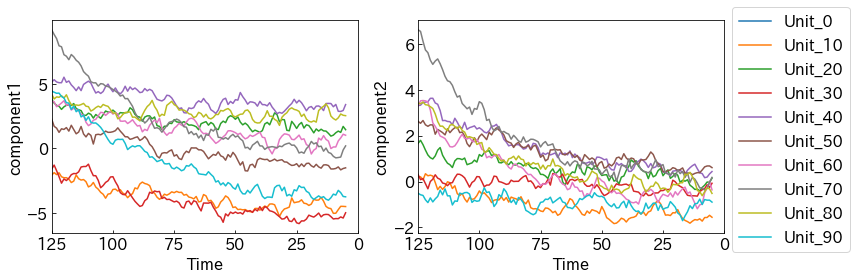

In [8]:
fig = plt.figure(figsize=(12,4))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    for j in range(pca_df["Unit"].nunique()):
        if j % 10 == 0:
            ax.plot("Time", f"component{i+1}", data=pca_df.query("Unit == @j"), label=f"Unit_{j}")
    ax.set_xlim([125,0])
    ax.set_xlabel("Time")
    ax.set_ylabel(f"component{i+1}")
    if i==1:
        ax.legend(loc=2,bbox_to_anchor=(1, 1.1))
fig.tight_layout()

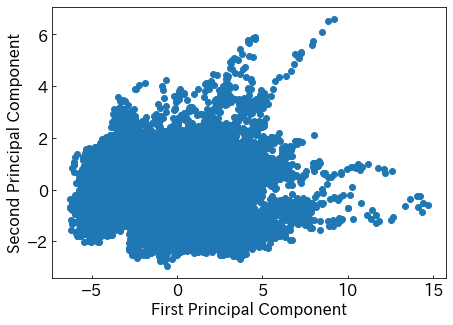

In [9]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
plt.scatter("component1","component2", data=pca_df)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component");

## ホテリングのT2法 (Htelling's T-square method) 

### ２次元のホテリング

In [10]:
def calculate_hotelling_abnormality(data, train_mean, train_covariance):
    '''分布推定と異常度の算出をおこなう
    
    Args:
            data (np.ndarray): 異常度を計算するデータ
            train_mean (np.ndarray): 学習データの平均
            train_covariance (np.ndarray): 学習データの分散共分散行列
            
    Returns:
            abnormarity (np.ndarray): 異常度
    '''
    
    abnormality = np.sum((data - train_mean).dot(np.linalg.inv(train_covariance)) * (data - train_mean), axis=1)
    
    return abnormality

In [11]:
def calculate_hotelling_threshold(ratio, M):
    '''データに対して異常と判断する閾値を求める.
    
    Args:
            ratio (float): 異常と判断する割合
            M (int): 特徴量の数
            
    Returns:
            threshold (float): 異常と判断する閾値
    '''
    
    threshold = stats.chi2.interval(1-ratio*2, M)[1]
    
    return threshold

In [12]:
def learn_hotelling(train_data, ratio):
    
    train_mean = np.mean(train_data, axis=0)
    train_covariance = np.cov(train_data.T)
    train_abnormality = calculate_hotelling_abnormality(train_data, train_mean, train_covariance)
    
    M = train_data.shape[1]
    threshold = calculate_hotelling_threshold(ratio, M)
    
    return train_mean, train_covariance, threshold, train_abnormality

In [13]:
train_data = np.array(pca_df[["component1", "component2"]])

In [14]:
train_data

array([[-1.83591999, -1.60748741],
       [-2.05048442, -1.70294813],
       [-2.37305018, -1.47649376],
       ...,
       [ 2.50516384,  1.82041625],
       [ 2.48388199,  1.72593951],
       [ 2.84034425,  1.88781422]])

In [15]:
ratio = 0.01
train_mean, train_covariance, threshold, train_abnormality = learn_hotelling(train_data, ratio)

In [16]:
threshold

9.21034037197618

In [17]:
print('train_mean: \n{}\n'.format(train_mean))
print('train_covariane: \n{}\n'.format(train_covariance))
print('threshold: \n{}\n'.format(threshold))
print('train_abnormality.shape: {}\ntrain_abnormality[0:5]: {}\n'.format(train_abnormality.shape, train_abnormality[0:5]))

train_mean: 
[ 9.39560642e-17 -5.63736385e-17]

train_covariane: 
[[ 1.07155149e+01 -1.71483989e-16]
 [-1.71483989e-16  1.59007803e+00]]

threshold: 
9.21034037197618

train_abnormality.shape: (12100,)
train_abnormality[0:5]: [1.93964085 2.21620392 1.89655715 2.31498161 2.46853531]



In [18]:
is_train_abnormal = train_abnormality > threshold

In [19]:
train_normal_data = train_data[~is_train_abnormal]
train_abnormal_data = train_data[is_train_abnormal]

In [20]:
train_normal_data.shape

(11957, 2)

In [21]:
train_abnormal_data.shape

(143, 2)

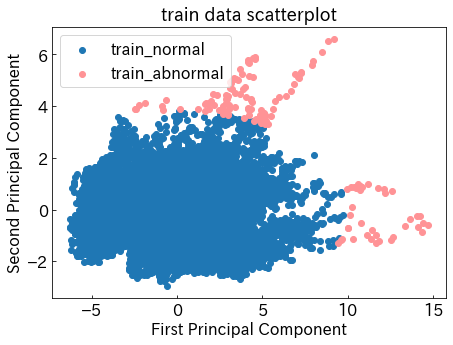

In [22]:
# 学習データの散布図
# 正常データの範囲を破線で示す
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
ax = fig.add_subplot(1,1,1)
ax.grid(False)

ax.scatter(train_normal_data[:, 0], train_normal_data[:, 1], label='train_normal')
ax.scatter(train_abnormal_data[:, 0], train_abnormal_data[:, 1],color="#ff9396" , label='train_abnormal')

ax.set_title('train data scatterplot')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();

In [23]:
pca_df["Abnormality"] = train_abnormality

Text(0, 0.5, 'Abnormality')

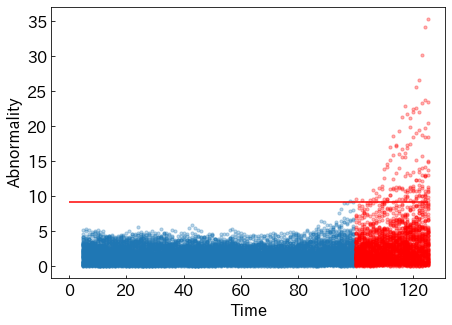

In [24]:
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
plt.scatter("Time", "Abnormality", data=pca_df.query("Time<100"), s=10, alpha=0.3)
plt.scatter("Time", "Abnormality", data=pca_df.query("Time>=100"), s=10, color='r',alpha=0.3)

plt.hlines(y=threshold, xmin=0, xmax=125, color='red')

plt.xlabel("Time")
plt.ylabel("Abnormality")

### １次元づつ異常度を算出する

In [25]:
train_c1 = np.array(pca_df["component1"])
train_c2 = np.array(pca_df["component2"])

In [26]:
def get_abnormal_hotelling(train_data, ratio, number_dim):
    
    # calculate basic statistical values
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    
    # calculate abnormality
    train_abnormality = ((train_data - train_mean)/train_std) ** 2
    
    # `stats.chi2.interval()` では両側%点が算出されることを考慮して `ratio*2` を用いる
    threshold =  stats.chi2.interval(1-ratio*2, number_dim)[1]
    
    # get lower limit and upper limit based on hotelling
    is_train_abnormal = train_abnormality > threshold
    train_normal_data = train_data[~is_train_abnormal]
    
    train_normal_min = np.min(train_normal_data)
    train_normal_max = np.max(train_normal_data)
    
    return threshold, train_abnormality, train_normal_min, train_normal_max

In [27]:
ratios = [0.01, 0.05]
threshold_c1 = []
abnormality_c1 = []
lower_bound_c1 = []
upper_bound_c1 = []
for ratio in ratios:
    threshold, train_abnormality, train_normal_min, train_normal_max = get_abnormal_hotelling(train_c1, ratio=ratio, number_dim=1)
    threshold_c1.append(threshold)
    abnormality_c1.append(train_abnormality)
    lower_bound_c1.append(train_normal_min)
    upper_bound_c1.append(train_normal_max)

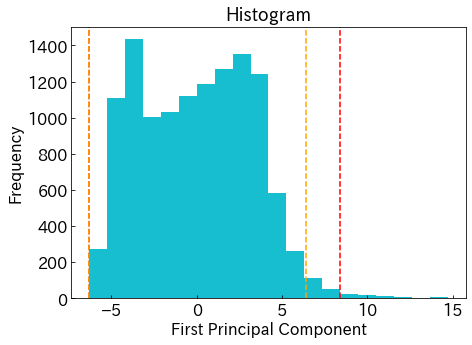

In [28]:
# 学習データのヒストグラム
# 正常データの範囲を破線で示す
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
ax = fig.add_subplot(1,1,1)

ax.hist(train_c1, bins=20, color="#17becf")
ax.axvline(lower_bound_c1[0], ls='--', c='r')
ax.axvline(upper_bound_c1[0], ls='--', c='r')
ax.axvline(lower_bound_c1[1], ls='--', c='orange')
ax.axvline(upper_bound_c1[1], ls='--', c='orange')

ax.set_title('Histogram')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Frequency');

In [29]:
ratios = [0.01, 0.05]
threshold_c2 = []
abnormality_c2 = []
lower_bound_c2 = []
upper_bound_c2 = []
for ratio in ratios:
    threshold, train_abnormality, train_normal_min, train_normal_max = get_abnormal_hotelling(train_c2, ratio=ratio, number_dim=1)
    threshold_c2.append(threshold)
    abnormality_c2.append(train_abnormality)
    lower_bound_c2.append(train_normal_min)
    upper_bound_c2.append(train_normal_max)

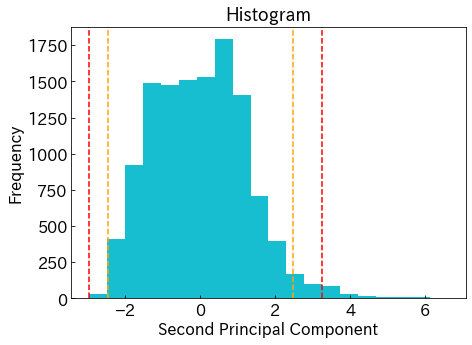

In [30]:
# 学習データのヒストグラム
# 正常データの範囲を破線で示す
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
ax = fig.add_subplot(1,1,1)

ax.hist(train_c2, bins=20, color="#17becf")
ax.axvline(lower_bound_c2[0], ls='--', c='r')
ax.axvline(upper_bound_c2[0], ls='--', c='r')
ax.axvline(lower_bound_c2[1], ls='--', c='orange')
ax.axvline(upper_bound_c2[1], ls='--', c='orange')

ax.set_title('Histogram')
ax.set_xlabel('Second Principal Component')
ax.set_ylabel('Frequency');

In [31]:
lower_bound_c1

[-6.2986728662643054, -6.2986728662643054]

In [32]:
upper_bound_c1

[8.394337518810003, 6.407886246778847]

In [33]:
lower_bound_c2

[-2.9575486364335126, -2.467206625442228]

In [34]:
upper_bound_c2

[3.2429910936412063, 2.471025411407215]

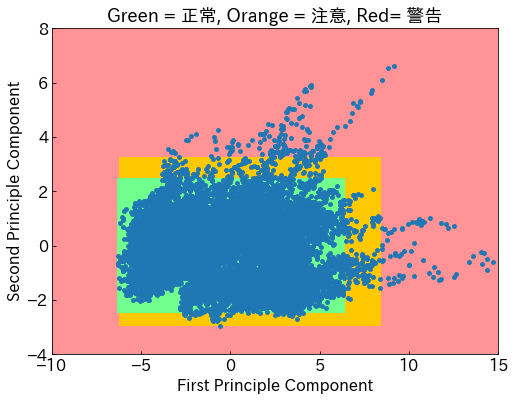

In [35]:
# prepare data
xx_urgent, yy_urgent = np.meshgrid(np.linspace(-10, 15, 500), np.linspace(-4, 8, 500))
urgent_empty_array = np.zeros([xx_urgent.shape[0], yy_urgent.shape[0]])

xx_attention, yy_attention = np.meshgrid(np.linspace(-6.2, 8.4, 500), np.linspace(-2.95, 3.24, 500))
attention_empty_array = np.zeros([xx_attention.shape[0], yy_attention.shape[0]])

xx_normal, yy_normal = np.meshgrid(np.linspace(-6.29, 6.4, 500), np.linspace(-2.46, 2.47, 500))
normal_empty_array = np.zeros([xx_normal.shape[0], yy_normal.shape[0]])

# plotting
plt.figure(figsize=(8, 6))
plt.contourf(xx_urgent, yy_urgent, urgent_empty_array, colors=["#ff9396"])

plt.contourf(xx_attention, yy_attention, attention_empty_array, colors=["#ffc900"])
plt.contourf(xx_normal, yy_normal, normal_empty_array, colors=["#71ff8d"])
plt.scatter(train_c1, train_c2, s=15)

plt.xlim([-10, 15])
plt.ylim([-4, 8])

plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
plt.title("Green = 正常, Orange = 注意, Red= 警告");

## ホテリング別の実装仕方

In [36]:
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet
from sklearn.model_selection import train_test_split

from scipy.stats import chi2

In [37]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#71ff8d", "#ff9396", "#ffc900",])

### EmpiricalCovarianceを使用した方法

参考：
* [井手剛「入門 機械学習による異常検知」 （コロナ社，2015）第2章のホテリング理論による異常検知を，Pythonのscikit-learnを使って試した。](https://gist.github.com/tatamiya/f549aaee716fc1429f588c2240277e51)

In [38]:
def abnormal_detection(train_data, model, ratio=0.01, ndims=2):
    
    # setting threshold 
    _, chi2_threshold = stats.chi2.interval(alpha=(1-ratio), df=ndims)
    
    abnormal_detection_model = model.fit(train_data)
    
    covariance = model.covariance_
    
    # calculate abnormality
    abnormality = model.mahalanobis(train_data)
    
    # abnormal condition
    abnormal_condition = model.mahalanobis(train_data) > chi2_threshold
    abnormal_data = train_data[abnormal_condition]
    normal_data = train_data[~abnormal_condition]
    
    return chi2_threshold, abnormality, abnormal_data, normal_data, model

In [39]:
chi2_threshold, abnormality, abnormal_data, normal_data, abnormal_model = abnormal_detection(train_data, EmpiricalCovariance())

/var/folders/nx/zg8x3j9172z1bl_8p_ss2vtm0000gq/T/ipykernel_40317/3436251796.py:4: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  _, chi2_threshold = stats.chi2.interval(alpha=(1-ratio), df=ndims)


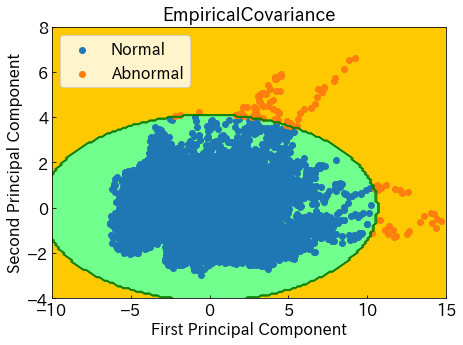

In [40]:
xx, yy = np.meshgrid(np.linspace(-10, 15, 150),
                     np.linspace(-4, 8, 150))

Z = abnormal_model.mahalanobis(np.c_[xx.ravel(), yy.ravel()]) > chi2_threshold
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
ax = fig.add_subplot(1,1,1)
ax.grid(False)

ax.contour(xx, yy, Z, linewidths=0.5, colors='green')
ax.contourf(xx, yy, Z, cmap=custom_cmap)

ax.scatter(normal_data[:,0],normal_data[:,1], label="Normal")
ax.scatter(abnormal_data[:,0],abnormal_data[:,1], label="Abnormal")

ax.set_title("EmpiricalCovariance")
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();

### Robustな共分散行列を用いた方法(MCD)

In [41]:
chi2_threshold, abnormality, abnormal_data, normal_data, abnormal_model = abnormal_detection(train_data, MinCovDet())

/var/folders/nx/zg8x3j9172z1bl_8p_ss2vtm0000gq/T/ipykernel_40317/3436251796.py:4: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  _, chi2_threshold = stats.chi2.interval(alpha=(1-ratio), df=ndims)


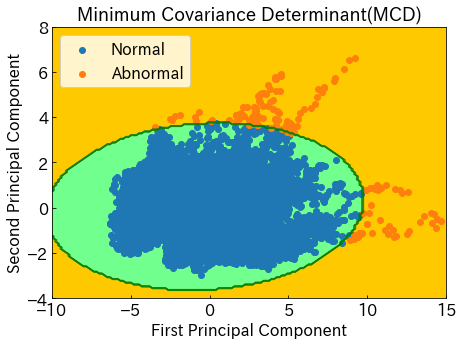

In [42]:
xx, yy = np.meshgrid(np.linspace(-10, 15, 150),
                     np.linspace(-4, 8, 150))

Z = abnormal_model.mahalanobis(np.c_[xx.ravel(), yy.ravel()]) > chi2_threshold
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
ax = fig.add_subplot(1,1,1)
ax.grid(False)

ax.contour(xx, yy, Z, linewidths=0.5, colors='green')
ax.contourf(xx, yy, Z, cmap=custom_cmap)

ax.scatter(normal_data[:,0],normal_data[:,1], label="Normal")
ax.scatter(abnormal_data[:,0],abnormal_data[:,1], label="Abnormal")

ax.set_title("Minimum Covariance Determinant(MCD)")
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend();